# **Install Package**

In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.78-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

# **Import Package**

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os
from ultralytics import YOLO
# from sklearn.metrics import precision_recall_fscore_support, average_precision_score

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Object Tracking, Deteksi Anomali, dan Klasifikasi**

In [ ]:
import time
import os
import cv2
import numpy as np
import tensorflow as tf

# Mulai pengukuran waktu
start_time = time.time()

# Load model YOLOv9 untuk deteksi objek
yolo_model = YOLO('/content/drive/MyDrive/Skripsi/Model YOLOV9 New/Result Model 1 (70:30)/weights/best.pt')

# Load model MobileNet untuk klasifikasi
model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/Model MobileNetv2/Result Skenario 2 (80:20) /my_model.h5')

# Membuat direktori jika belum ada untuk menyimpan frame anomali
os.makedirs('/content/anomali', exist_ok=True)
os.makedirs('/content/anomaliwithboundingbox', exist_ok=True)  # Direktori untuk frame dengan bounding box

# Fungsi untuk mengklasifikasi gambar menggunakan MobileNet
def classify_image(image):
    resized_image = cv2.resize(image, (224, 224))  # Resize gambar ke ukuran 224x224
    normalized_image = resized_image.astype('float32') / 255.0  # Normalisasi pixel ke rentang [0,1]
    input_image = np.expand_dims(normalized_image, axis=0)  # Tambahkan dimensi batch
    predictions = model.predict(input_image)  # Prediksi menggunakan model MobileNet

    # Menggunakan sigmoid untuk hasil prediksi biner (accident / no-accident)
    predicted_class = (predictions[0] > 0.5).astype(int)  # Threshold 0.5 untuk klasifikasi
    class_labels = ['accident', 'no-accident']

    return class_labels[predicted_class[0]]  # Kembalikan label hasil klasifikasi

# Fungsi untuk menghitung rata-rata bergerak
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Fungsi untuk menghitung jarak antara dua titik (digunakan untuk menghitung kecepatan)
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Inisialisasi dictionary untuk menyimpan riwayat pergerakan dan kecepatan objek
movement_history = {}
speed_history = {}

# Buka video yang akan dianalisis
video_input_path = "/content/drive/MyDrive/Skripsi/Data Video/Data Uji/no accident/youtube1.mp4"
video_capture = cv2.VideoCapture(video_input_path)

# Jalankan model YOLOv9 untuk tracking objek pada video
results = yolo_model.track(source=video_input_path, save=True, stream=True, persist=True, tracker="bytetrack.yaml")

frame_num = 0  # Inisialisasi nomor frame
anomaly_info = []  # List untuk menyimpan informasi anomali

# Loop utama untuk memproses setiap frame dari video
for result in results:
    if result.boxes is None or len(result.boxes) == 0:
        frame_num += 1
        continue  # Lewati frame jika tidak ada objek terdeteksi

    boxes = result.boxes  # Ambil bounding box dari hasil YOLO
    annotated_frame = result.orig_img.copy()  # Salin frame asli untuk anotasi

    for box in boxes:
        obj_id = box.id.item() if box.id is not None else None  # Ambil ID objek
        class_id = int(box.cls) if box.cls is not None else None  # Ambil kelas objek
        label = yolo_model.names[class_id] if class_id is not None else "Unknown"  # Ambil label objek

        if obj_id is None:
            continue  # Lewati jika ID objek tidak tersedia

        # Koordinat bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        center = ((x1 + x2) / 2, (y1 + y2) / 2)  # Hitung pusat objek

        # Simpan riwayat pergerakan objek
        if obj_id not in movement_history:
            movement_history[obj_id] = []
            speed_history[obj_id] = []

        movement_history[obj_id].append(center)

        # Hitung kecepatan jika ada riwayat pergerakan sebelumnya
        if len(movement_history[obj_id]) > 1:
            prev_center = movement_history[obj_id][-2]
            current_speed = calculate_distance(center, prev_center)  # Hitung kecepatan saat ini
            speed_history[obj_id].append(current_speed)

            # Jika ada cukup data, hitung rata-rata kecepatan
            if len(speed_history[obj_id]) >= 25:
                avg_speed = moving_average(speed_history[obj_id], window_size=25)[-1]

                # Deteksi berhenti mendadak
                if avg_speed > 5 and current_speed < 3:
                    # Simpan informasi anomali
                    anomaly_info.append({
                        "frame_num": frame_num,
                        "label": label,
                        "obj_id": obj_id,
                        "current_speed": current_speed,
                        "avg_speed": avg_speed,
                        "image_no_bbox": result.orig_img.copy(),  # Simpan frame tanpa bounding box
                        "bounding_box": (x1, y1, x2, y2)
                    })

                    # Tambahkan bounding box merah pada frame anomali
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    text = f"Anomaly"
                    cv2.putText(annotated_frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                    # Simpan frame dengan bounding box
                    anomaly_info[-1]["image_with_bbox"] = annotated_frame.copy()

        # Cetak informasi objek setiap frame
        print(f"Frame {frame_num} - Object ID: {obj_id}, Label: {label}, Current Speed: {current_speed:.2f} units, "
              f"Bounding Box: ({x1}, {y1}), ({x2}, {y2})")

    frame_num += 1

# Pilih 2 frame dengan tingkat anomali tertinggi
top_anomalies = sorted(anomaly_info, key=lambda x: x['avg_speed'] - x['current_speed'], reverse=True)[:2]

# Simpan frame anomali ke dalam folder yang telah dibuat
for idx, anomaly in enumerate(top_anomalies, start=1):
    no_bbox_path = f"/content/anomali/top_anomaly_{idx:02d}_frame_{anomaly['frame_num']:04d}.jpg"
    cv2.imwrite(no_bbox_path, anomaly["image_no_bbox"])

    with_bbox_path = f"/content/anomaliwithboundingbox/top_anomaly_{idx:02d}_frame_{anomaly['frame_num']:04d}_bbox.jpg"
    cv2.imwrite(with_bbox_path, anomaly["image_with_bbox"])

    print(f"Anomaly Detected: \n Frame {anomaly['frame_num']} - ID: {anomaly['obj_id']}, Object: {anomaly['label']}, current_speed: {anomaly['current_speed']}, avg_speed: {anomaly['avg_speed']}")

# Akhiri pengukuran waktu
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Proses selesai dalam {elapsed_time:.2f} detik.")



video 1/1 (frame 1/294) /content/drive/MyDrive/Skripsi/Data Video/Data Uji/no accident/youtube1.mp4: 384x640 7 cars, 2 trucks, 32.9ms
Frame 0 - Object ID: 1.0, Label: car, Current Speed: 2.00 units, Bounding Box: (519, 181), (585, 263)
Frame 0 - Object ID: 2.0, Label: car, Current Speed: 2.00 units, Bounding Box: (689, 47), (732, 93)
Frame 0 - Object ID: 3.0, Label: truck, Current Speed: 2.00 units, Bounding Box: (0, 546), (1070, 1077)
Frame 0 - Object ID: 4.0, Label: car, Current Speed: 2.00 units, Bounding Box: (536, 104), (583, 146)
Frame 0 - Object ID: 5.0, Label: truck, Current Speed: 2.00 units, Bounding Box: (230, 337), (534, 633)
Frame 0 - Object ID: 6.0, Label: car, Current Speed: 2.00 units, Bounding Box: (429, 139), (490, 199)
Frame 0 - Object ID: 7.0, Label: car, Current Speed: 2.00 units, Bounding Box: (1528, 365), (1595, 420)
Frame 0 - Object ID: 8.0, Label: car, Current Speed: 2.00 units, Bounding Box: (546, 6), (574, 40)
Frame 0 - Object ID: 9.0, Label: car, Current Sp

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


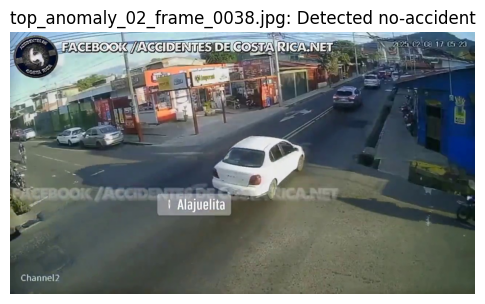

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


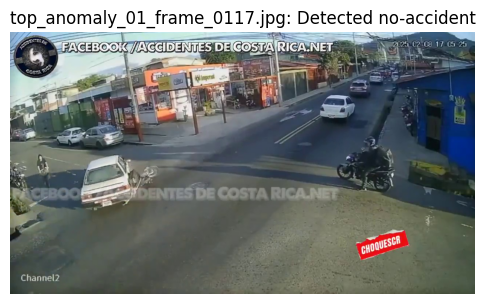

In [ ]:
  import cv2
import matplotlib.pyplot as plt

# Klasifikasi frame anomali dan tampilkan hasilnya
for anomalous_frame in os.listdir('/content/anomali'):
    frame_path = os.path.join('/content/anomali', anomalous_frame)
    frame = cv2.imread(frame_path)

    if frame is None:
        print(f"Frame {anomalous_frame} tidak bisa dibaca. Lewati.")
        continue

    # Klasifikasi gambar
    accident_class = classify_image(frame)

    # Konversi BGR ke RGB untuk ditampilkan dengan matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  #  Tampilkan gambar dengan matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"{anomalous_frame}: Detected {accident_class}", fontsize=12)
    plt.show()

# **...**

In [ ]:
import shutil

# Tentukan path folder yang ingin dihapus
folder_path = '/content/runs'  # Ganti dengan path folder yang ingin Anda hapus

# Hapus folder dan seluruh isinya
shutil.rmtree(folder_path)

print(f"Folder {folder_path} berhasil dihapus beserta isinya.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs'

In [ ]:
import shutil

# Tentukan path folder yang ingin dihapus
folder_path = '/content/anomali'  # Ganti dengan path folder yang ingin Anda hapus

# Hapus folder dan seluruh isinya
shutil.rmtree(folder_path)

print(f"Folder {folder_path} berhasil dihapus beserta isinya.")


In [ ]:
import shutil

# Tentukan path folder yang ingin dihapus
folder_path = '/content/anomaliwithboundingbox'  # Ganti dengan path folder yang ingin Anda hapus

# Hapus folder dan seluruh isinya
shutil.rmtree(folder_path)

print(f"Folder {folder_path} berhasil dihapus beserta isinya.")
